# 基于LSTM的自然语言处理

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 多分类-预训练词向量

### 数据准备

In [2]:
# 加载语料，酒店评论
data = pd.read_csv('../../../../../data/03.nlp/ChineseNlpCorpus/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv')
data = data.dropna()
data

,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"
...,...,...
7761,0,尼斯酒店的几大特点：噪音大、环境差、配置低、服务效率低。如：1、隔壁歌厅的声音闹至午夜3点许...
7762,0,盐城来了很多次，第一次住盐阜宾馆，我的确很失望整个墙壁黑咕隆咚的，好像被烟熏过一样家具非常的...
7763,0,看照片觉得还挺不错的，又是4星级的，但入住以后除了后悔没有别的，房间挺大但空空的，早餐是有但...
7764,0,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...


In [3]:
def generator(data_list, train_ratio, tokenizer, batch_size, max_length: int = 128):
    """
    读取数据，并对数据进行划分，生成加载器

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入数据，包含数据和标签
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    tokenizer : {}
        分词器
    batch_size : {int} 
        输入数据的批次大小，正整数
    max_length : {int} 
        最大文本截取长度，正整数

    返回值
    -------
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器
    """
    # 获取数据
    texts = data_list[0]  # 特征
    labels = data_list[1]  # 目标
    
    # 划分数据
    train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=1-train_ratio, random_state=42)

    # 定义数据集的Dataset类
    class CustomDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
    
        def __len__(self):
            return len(self.labels)
    
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            
            # 对文本进行token化，并转换为输入id和attention mask
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors="pt"
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'labels': torch.tensor(label, dtype=torch.long)
            }

    # 创建Dataset和DataLoader
    train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=max_length)
    val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 查看数据划分结果
    print("train_dataset:", len(train_dataset))
    print("val_dataset:", len(val_dataset))

    return train_dataset, val_dataset, train_loader, valid_loader

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
# 构造参数字典
params1 = {
    "data_list": [data['review'].values, data['label'].values],
    "train_ratio": 0.9,
    "tokenizer": tokenizer,
    "batch_size": 32,
    "max_length": 128,
}

# 函数传参
train_dataset, val_dataset, train_loader, valid_loader = generator(**params1)

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

train_dataset: 6988
val_dataset: 777


In [5]:
sample = train_dataset[0]  # 获取第一个样本
input_ids = sample['input_ids']  # 提取 input_ids
input_ids

tensor([ 101,  122,  119, 1372, 3300,  671, 2207, 6956,  819, 2791, 3300,  117,
         679, 3221, 1048, 4638,  117, 6206, 1217, 3119, 8115, 1039,  120, 1921,
         119,  123,  119, 4495, 2345,  117, 2791, 1765, 3691, 2523,  117,  671,
         671,  679, 4761, 6887, 3221,  784, 3890, 4522,  678, 4638, 7946, 5682,
        1750, 1750, 4575,  117, 1072, 3819, 2533,  679,  746,  117, 3315, 3221,
        4635, 5682, 4638,  117,  852, 3221, 5682, 4692, 6629, 4129,  119,  677,
        7481, 3300, 2523, 1914, 2207, 3822,  119, 1369, 1912,  117, 4692, 1168,
        6096, 6082, 1788, 4197, 4638, 3430, 2094,  677, 4260, 1343,  119,  119,
         119,  119,  119,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [6]:
sample['labels']

tensor(0)

### 模型定义

In [7]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # 嵌入层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # LSTM层
        self.fc = nn.Linear(hidden_dim, num_classes)  # 全连接层
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        _, (hidden, _) = self.lstm(embedded)  # hidden: [1, batch_size, hidden_dim]
        hidden = hidden.squeeze(0)  # [batch_size, hidden_dim]
        output = self.fc(self.dropout(hidden))  # [batch_size, output_dim]
        return output

### 模型训练

In [8]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay= 1e-4)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        train_correct_predictions = 0
        for batch in train_loader:
            # 将数据移至 device
            batch_x = batch['input_ids'].to(device)
            batch_y = batch['labels'].to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值
            # 计算准确率
            _, preds = torch.max(outputs, dim=1)
            
            train_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 计算准确率
        train_accuracy = train_correct_predictions.double() / len(train_loader.dataset)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            val_correct_predictions = 0
            for batch in valid_loader:
                # 将数据移至 device
                batch_x = batch['input_ids'].to(device)
                batch_y = batch['labels'].to(device)
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
                val_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 计算准确率
        val_accuracy = val_correct_predictions.double() / len(valid_loader.dataset)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_loss, val_loss):
        """
        绘制训练和验证损失曲线

        参数:
        - train_loss: 训练损失数组
        - val_loss: 验证损失数组
        """
        # 自动生成 epochs（假设train_loss和val_loss长度一致）
        epochs = np.arange(len(train_loss))

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white")

        # 创建图形并优化细节
        plt.figure(figsize=(10, 6))

        # 绘制训练和验证曲线
        plt.plot(epochs, train_loss, label='Training', color='#d62728', linewidth=2, marker='o', markersize=6)
        plt.plot(epochs, val_loss, label='Validation', color='#1f77b4', linewidth=2, marker='s', markersize=6)

        # 添加标题和标签
        plt.title('Training and Validation Loss', fontsize=18, fontweight='bold', color='black')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)

        # 添加图例
        plt.legend(fontsize=12, loc='upper right')

        # 启用横向网格线
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # 可选：修改左侧和底部边框的样式
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)

        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)

        plt.gca().tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 展示图形
        plt.show()

    if plots:
        plot_loss(train_losses, val_losses)

    return model

In [9]:
# 构造参数字典
params2 = {
    "train_args": {
        "model_name": LSTM,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.CrossEntropyLoss(),
        "patience": 10,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/LSTM",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'vocab_size': tokenizer.vocab_size,
        'embedding_dim': 256,
        'hidden_dim': 128,
        'num_classes': 2,
    },
}
model = train(**params2)

AssertionError: Torch not compiled with CUDA enabled

### 模型预测

In [23]:
def predict(predict_args, model_args):
    # 参数配置
    texts = predict_args['texts']
    model_name = predict_args['model_name']
    tokenizer = predict_args['tokenizer']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    max_length = predict_args['max_length']

    # 检查可用device
    device = torch.device(device)

    # 加载分词器
    encoding = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 模型预测
    model.eval()
    with torch.no_grad():
        X_true = encoding['input_ids'].squeeze(0).to(device)
        outputs = model(X_true)
        _, preds = torch.max(outputs, dim=1)
        labels = preds.cpu().detach().numpy()

    # 将原始数据与预测数据合并输出
    y_pred = pd.DataFrame({'text': texts, 'label': labels})

    return y_pred

In [24]:
# 构造参数字典
params3 = {
    "predict_args": {
        "model_name": LSTM,
        "model_path": "../outputs/best_models/LSTM/checkpoint.pth",
        "texts": [data['review'][4000], data['review'][7000]],
        "tokenizer": tokenizer,
        "max_length": 128,
        "device": 'cpu'
    },
    "model_args": {
        'vocab_size': tokenizer.vocab_size,
        'embedding_dim': 256,
        'hidden_dim': 128,
        'num_classes': 2,
    },
}
y_pred = predict(**params3)

In [25]:
y_pred

,text,label
0,这家酒店不错，入住的30楼，可以直接看到玄武湖，风景不错，房里的飘窗做得有特色，喜欢！床也很...,1
1,"隔音效果非常差,基本上隔壁房间的说话声都能听到.最后一天隔壁老早起来吵架,简直就是对着你在说...",0


## 二分类-预训练词向量

### 数据准备

In [26]:
# 加载语料，酒店评论
data = pd.read_csv('../../../../../data/03.nlp/ChineseNlpCorpus/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv')
data = data.dropna()
data

,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"
...,...,...
7761,0,尼斯酒店的几大特点：噪音大、环境差、配置低、服务效率低。如：1、隔壁歌厅的声音闹至午夜3点许...
7762,0,盐城来了很多次，第一次住盐阜宾馆，我的确很失望整个墙壁黑咕隆咚的，好像被烟熏过一样家具非常的...
7763,0,看照片觉得还挺不错的，又是4星级的，但入住以后除了后悔没有别的，房间挺大但空空的，早餐是有但...
7764,0,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...


In [27]:
def generator(data_list, train_ratio, tokenizer, batch_size, max_length: int = 128):
    """
    读取数据，并对数据进行划分，生成加载器

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入数据，包含数据和标签
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    tokenizer : {}
        分词器
    batch_size : {int} 
        输入数据的批次大小，正整数
    max_length : {int} 
        最大文本截取长度，正整数

    返回值
    -------
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器
    """
    # 获取数据
    texts = data_list[0]  # 特征
    labels = data_list[1]  # 目标
    
    # 划分数据
    train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=1-train_ratio, random_state=42)

    # 定义数据集的Dataset类
    class CustomDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
    
        def __len__(self):
            return len(self.labels)
    
        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            
            # 对文本进行token化，并转换为输入id和attention mask
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors="pt"
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'labels': torch.tensor(label, dtype=torch.float)
            }

    # 创建Dataset和DataLoader
    train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length=max_length)
    val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length=max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 查看数据划分结果
    print("train_dataset:", len(train_dataset))
    print("val_dataset:", len(val_dataset))

    return train_dataset, val_dataset, train_loader, valid_loader

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
# 构造参数字典
params1 = {
    "data_list": [data['review'].values, data['label'].values],
    "train_ratio": 0.9,
    "tokenizer": tokenizer,
    "batch_size": 32,
    "max_length": 128,
}

# 函数传参
train_dataset, val_dataset, train_loader, valid_loader = generator(**params1)

train_dataset: 6988
val_dataset: 777


### 模型定义

In [29]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # 嵌入层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # LSTM层
        self.fc = nn.Linear(hidden_dim, output_dim)  # 全连接层
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        _, (hidden, _) = self.lstm(embedded)  # hidden: [1, batch_size, hidden_dim]
        hidden = hidden.squeeze(0)  # [batch_size, hidden_dim]
        output = self.fc(self.dropout(hidden))  # [batch_size, output_dim]
        return output.squeeze(-1)

### 模型训练

In [30]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay= 1e-4)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        train_correct_predictions = 0
        for batch in train_loader:
            # 将数据移至 device
            batch_x = batch['input_ids'].to(device)
            batch_y = batch['labels'].to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            # print(outputs)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值
            # 计算准确率
            probs = torch.sigmoid(outputs)  # 转换为概率值
            preds = (probs > 0.5).long()  
            
            train_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 计算准确率
        train_accuracy = train_correct_predictions.double() / len(train_loader.dataset)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            val_correct_predictions = 0
            for batch in valid_loader:
                # 将数据移至 device
                batch_x = batch['input_ids'].to(device)
                batch_y = batch['labels'].to(device)
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()
                # 计算准确率
                probs = torch.sigmoid(outputs)  # 转换为概率值
                preds = (probs > 0.5).long()  
                val_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 计算准确率
        val_accuracy = val_correct_predictions.double() / len(valid_loader.dataset)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_loss, val_loss):
        """
        绘制训练和验证损失曲线

        参数:
        - train_loss: 训练损失数组
        - val_loss: 验证损失数组
        """
        # 自动生成 epochs（假设train_loss和val_loss长度一致）
        epochs = np.arange(len(train_loss))

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white")

        # 创建图形并优化细节
        plt.figure(figsize=(10, 6))

        # 绘制训练和验证曲线
        plt.plot(epochs, train_loss, label='Training', color='#d62728', linewidth=2, marker='o', markersize=6)
        plt.plot(epochs, val_loss, label='Validation', color='#1f77b4', linewidth=2, marker='s', markersize=6)

        # 添加标题和标签
        plt.title('Training and Validation Loss', fontsize=18, fontweight='bold', color='black')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)

        # 添加图例
        plt.legend(fontsize=12, loc='upper right')

        # 启用横向网格线
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # 可选：修改左侧和底部边框的样式
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)

        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)

        plt.gca().tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 展示图形
        plt.show()

    if plots:
        plot_loss(train_losses, val_losses)

    return model

  2%|█▋                                                                                 | 1/50 [00:14<11:33, 14.16s/it]

Epoch [1/50], Training Loss: 0.6146, Training Accuracy: 0.6832, Validation Loss: 0.6341, Validation Accuracy: 0.6731
Validation loss decreased (inf --> 0.634135).  Saving model ...
Updating learning rate to 0.0009990133642141358


  4%|███▎                                                                               | 2/50 [00:28<11:14, 14.05s/it]

Epoch [2/50], Training Loss: 0.5976, Training Accuracy: 0.7095, Validation Loss: 0.6142, Validation Accuracy: 0.6718
Validation loss decreased (0.634135 --> 0.614153).  Saving model ...
Updating learning rate to 0.000996057350657239


  6%|████▉                                                                              | 3/50 [00:41<10:55, 13.95s/it]

Epoch [3/50], Training Loss: 0.5635, Training Accuracy: 0.7278, Validation Loss: 0.5814, Validation Accuracy: 0.7027
Validation loss decreased (0.614153 --> 0.581374).  Saving model ...
Updating learning rate to 0.0009911436253643444


  8%|██████▋                                                                            | 4/50 [00:55<10:33, 13.76s/it]

Epoch [4/50], Training Loss: 0.5718, Training Accuracy: 0.7202, Validation Loss: 0.6325, Validation Accuracy: 0.6229
EarlyStopping counter: 1 out of 10
Updating learning rate to 0.0009842915805643156


 10%|████████▎                                                                          | 5/50 [01:08<10:14, 13.65s/it]

Epoch [5/50], Training Loss: 0.6031, Training Accuracy: 0.6938, Validation Loss: 0.5957, Validation Accuracy: 0.6834
EarlyStopping counter: 2 out of 10
Updating learning rate to 0.0009755282581475768


 12%|█████████▉                                                                         | 6/50 [01:22<09:58, 13.61s/it]

Epoch [6/50], Training Loss: 0.5596, Training Accuracy: 0.7157, Validation Loss: 0.5248, Validation Accuracy: 0.7349
Validation loss decreased (0.581374 --> 0.524800).  Saving model ...
Updating learning rate to 0.0009648882429441257


 14%|███████████▌                                                                       | 7/50 [01:35<09:43, 13.56s/it]

Epoch [7/50], Training Loss: 0.6126, Training Accuracy: 0.6836, Validation Loss: 0.6315, Validation Accuracy: 0.6667
EarlyStopping counter: 1 out of 10
Updating learning rate to 0.0009524135262330098


 16%|█████████████▎                                                                     | 8/50 [01:49<09:28, 13.53s/it]

Epoch [8/50], Training Loss: 0.6092, Training Accuracy: 0.6886, Validation Loss: 0.6235, Validation Accuracy: 0.6654
EarlyStopping counter: 2 out of 10
Updating learning rate to 0.0009381533400219318


 18%|██████████████▉                                                                    | 9/50 [02:02<09:13, 13.50s/it]

Epoch [9/50], Training Loss: 0.5999, Training Accuracy: 0.7023, Validation Loss: 0.6015, Validation Accuracy: 0.6898
EarlyStopping counter: 3 out of 10
Updating learning rate to 0.0009221639627510075


 20%|████████████████▍                                                                 | 10/50 [02:16<08:59, 13.48s/it]

Epoch [10/50], Training Loss: 0.5831, Training Accuracy: 0.7202, Validation Loss: 0.6087, Validation Accuracy: 0.6937
EarlyStopping counter: 4 out of 10
Updating learning rate to 0.0009045084971874737


 22%|██████████████████                                                                | 11/50 [02:29<08:45, 13.47s/it]

Epoch [11/50], Training Loss: 0.6053, Training Accuracy: 0.6999, Validation Loss: 0.6063, Validation Accuracy: 0.7001
EarlyStopping counter: 5 out of 10
Updating learning rate to 0.0008852566213878947


 24%|███████████████████▋                                                              | 12/50 [02:43<08:31, 13.46s/it]

Epoch [12/50], Training Loss: 0.5911, Training Accuracy: 0.7181, Validation Loss: 0.6213, Validation Accuracy: 0.6680
EarlyStopping counter: 6 out of 10
Updating learning rate to 0.0008644843137107057


 26%|█████████████████████▎                                                            | 13/50 [02:56<08:18, 13.46s/it]

Epoch [13/50], Training Loss: 0.5730, Training Accuracy: 0.7198, Validation Loss: 0.5272, Validation Accuracy: 0.7362
EarlyStopping counter: 7 out of 10
Updating learning rate to 0.0008422735529643444


 28%|██████████████████████▉                                                           | 14/50 [03:10<08:04, 13.47s/it]

Epoch [14/50], Training Loss: 0.4445, Training Accuracy: 0.8014, Validation Loss: 0.3990, Validation Accuracy: 0.8314
Validation loss decreased (0.524800 --> 0.399045).  Saving model ...
Updating learning rate to 0.0008187119948743449


 30%|████████████████████████▌                                                         | 15/50 [03:24<07:56, 13.62s/it]

Epoch [15/50], Training Loss: 0.3233, Training Accuracy: 0.8751, Validation Loss: 0.3541, Validation Accuracy: 0.8520
Validation loss decreased (0.399045 --> 0.354059).  Saving model ...
Updating learning rate to 0.0007938926261462366


 32%|██████████████████████████▏                                                       | 16/50 [03:37<07:41, 13.58s/it]

Epoch [16/50], Training Loss: 0.2831, Training Accuracy: 0.8932, Validation Loss: 0.3293, Validation Accuracy: 0.8649
Validation loss decreased (0.354059 --> 0.329305).  Saving model ...
Updating learning rate to 0.0007679133974894983


 34%|███████████████████████████▉                                                      | 17/50 [03:50<07:26, 13.52s/it]

Epoch [17/50], Training Loss: 0.2395, Training Accuracy: 0.9177, Validation Loss: 0.3539, Validation Accuracy: 0.8559
EarlyStopping counter: 1 out of 10
Updating learning rate to 0.0007408768370508576


 36%|█████████████████████████████▌                                                    | 18/50 [04:04<07:14, 13.56s/it]

Epoch [18/50], Training Loss: 0.2111, Training Accuracy: 0.9266, Validation Loss: 0.3417, Validation Accuracy: 0.8662
EarlyStopping counter: 2 out of 10
Updating learning rate to 0.0007128896457825364


 38%|███████████████████████████████▏                                                  | 19/50 [04:18<07:03, 13.67s/it]

Epoch [19/50], Training Loss: 0.1956, Training Accuracy: 0.9363, Validation Loss: 0.3449, Validation Accuracy: 0.8674
EarlyStopping counter: 3 out of 10
Updating learning rate to 0.0006840622763423391


 40%|████████████████████████████████▊                                                 | 20/50 [04:31<06:48, 13.62s/it]

Epoch [20/50], Training Loss: 0.1708, Training Accuracy: 0.9452, Validation Loss: 0.4193, Validation Accuracy: 0.8623
EarlyStopping counter: 4 out of 10
Updating learning rate to 0.0006545084971874737


 42%|██████████████████████████████████▍                                               | 21/50 [04:45<06:33, 13.57s/it]

Epoch [21/50], Training Loss: 0.1586, Training Accuracy: 0.9523, Validation Loss: 0.4037, Validation Accuracy: 0.8597
EarlyStopping counter: 5 out of 10
Updating learning rate to 0.0006243449435824276


 44%|████████████████████████████████████                                              | 22/50 [04:59<06:21, 13.63s/it]

Epoch [22/50], Training Loss: 0.1387, Training Accuracy: 0.9582, Validation Loss: 0.3865, Validation Accuracy: 0.8674
EarlyStopping counter: 6 out of 10
Updating learning rate to 0.0005936906572928624


 46%|█████████████████████████████████████▋                                            | 23/50 [05:12<06:07, 13.61s/it]

Epoch [23/50], Training Loss: 0.1341, Training Accuracy: 0.9621, Validation Loss: 0.3960, Validation Accuracy: 0.8623
EarlyStopping counter: 7 out of 10
Updating learning rate to 0.0005626666167821521


 48%|███████████████████████████████████████▎                                          | 24/50 [05:26<05:53, 13.58s/it]

Epoch [24/50], Training Loss: 0.1219, Training Accuracy: 0.9662, Validation Loss: 0.4490, Validation Accuracy: 0.8610
EarlyStopping counter: 8 out of 10
Updating learning rate to 0.0005313952597646568


 50%|█████████████████████████████████████████                                         | 25/50 [05:39<05:39, 13.57s/it]

Epoch [25/50], Training Loss: 0.1044, Training Accuracy: 0.9747, Validation Loss: 0.4404, Validation Accuracy: 0.8674
EarlyStopping counter: 9 out of 10
Updating learning rate to 0.0005


 50%|█████████████████████████████████████████                                         | 25/50 [05:53<05:53, 14.14s/it]

Epoch [26/50], Training Loss: 0.1000, Training Accuracy: 0.9737, Validation Loss: 0.4637, Validation Accuracy: 0.8584
EarlyStopping counter: 10 out of 10
Early stopping!


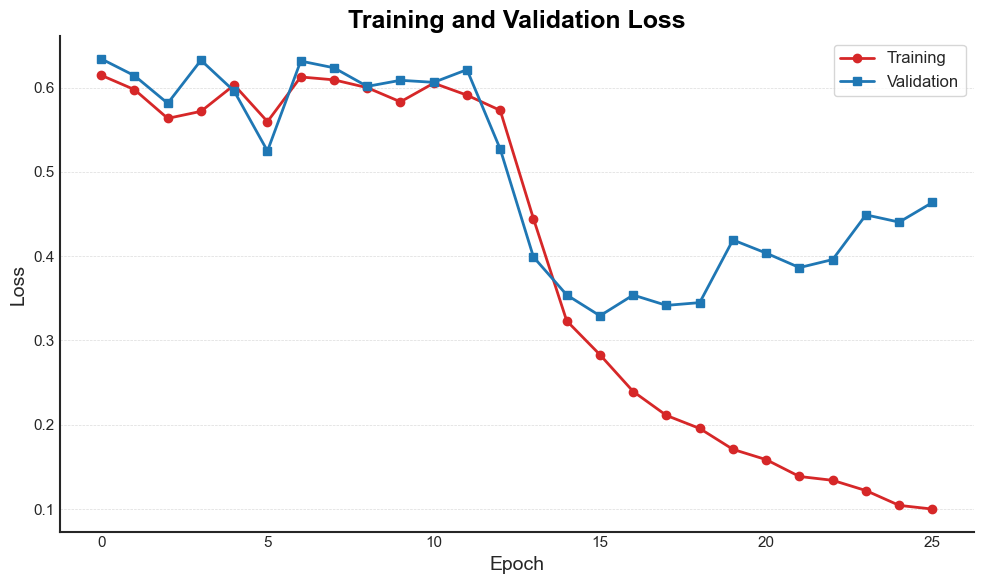

In [31]:
# 构造参数字典
params2 = {
    "train_args": {
        "model_name": LSTM,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.BCEWithLogitsLoss(),
        "patience": 10,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/LSTM",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'vocab_size': tokenizer.vocab_size,
        'embedding_dim': 256,
        'hidden_dim': 128,
        'output_dim': 1,
    },
}
model = train(**params2)

### 模型预测

In [35]:
def predict(predict_args, model_args):
    # 参数配置
    texts = predict_args['texts']
    model_name = predict_args['model_name']
    tokenizer = predict_args['tokenizer']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    max_length = predict_args['max_length']

    # 检查可用device
    device = torch.device(device)

    # 加载分词器
    encoding = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 模型预测
    model.eval()
    with torch.no_grad():
        X_true = encoding['input_ids'].squeeze(0).to(device)
        outputs = model(X_true)
        probs = torch.sigmoid(outputs)  # 转换为概率值
        preds = (probs > 0.5).long()  
        labels = preds.cpu().detach().numpy()

    # 将原始数据与预测数据合并输出
    y_pred = pd.DataFrame({'text': texts, 'label': labels})

    return y_pred

In [36]:
# 构造参数字典
params3 = {
    "predict_args": {
        "model_name": LSTM,
        "model_path": "../outputs/best_models/LSTM/checkpoint.pth",
        "texts": [data['review'][4000], data['review'][7000]],
        "tokenizer": tokenizer,
        "max_length": 128,
        "device": 'cpu'
    },
    "model_args": {
        'vocab_size': tokenizer.vocab_size,
        'embedding_dim': 256,
        'hidden_dim': 128,
        'output_dim': 1,
    },
}
y_pred = predict(**params3)

In [37]:
y_pred

,text,label
0,这家酒店不错，入住的30楼，可以直接看到玄武湖，风景不错，房里的飘窗做得有特色，喜欢！床也很...,1
1,"隔音效果非常差,基本上隔壁房间的说话声都能听到.最后一天隔壁老早起来吵架,简直就是对着你在说...",0


## 多分类-训练词向量

In [2]:
from gensim.models import FastText
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import jieba

### 数据准备

In [3]:
# 加载语料，酒店评论
data = pd.read_csv('../../../../../data/03.nlp/ChineseNlpCorpus/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv')
data = data.dropna().reset_index(drop=True)
data

,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"
...,...,...
7760,0,尼斯酒店的几大特点：噪音大、环境差、配置低、服务效率低。如：1、隔壁歌厅的声音闹至午夜3点许...
7761,0,盐城来了很多次，第一次住盐阜宾馆，我的确很失望整个墙壁黑咕隆咚的，好像被烟熏过一样家具非常的...
7762,0,看照片觉得还挺不错的，又是4星级的，但入住以后除了后悔没有别的，房间挺大但空空的，早餐是有但...
7763,0,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...


In [4]:
def tokenizer(texts, stopwords_path):
    """
    读取数据，并对数据进行分词

    参数说明
    ----------
    texts : {List[]}
        输入数据，列表形式，例如texts[0]代表一段文本
    stopwords_path : {str}
        停用词文件路径

    返回值
    -------
    sentences : {List[[]]}
        分词结果，列表形式，例如texts[0]代表一段文本，texts[0][0]代表改文本中的一个分词结果
    """
    # 去除停用词和标点
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        stop_words = set(f.read().splitlines())
    # stop_words = set(['，', '。', '的', '了', '是', '.', ',', '!', '"'])  # 停用词示例，可扩展

    # 分词
    sentences = [
        [word for word in jieba.lcut(str(texts[row]).strip()) if word not in stop_words]
        for row in range(len(texts))
        if isinstance(texts[row], str)
    ]

    return sentences

In [5]:
def generator(data_list, train_ratio, tokenizer, stopwords_path, vector_size, batch_size, max_length: int = 128):
    """
    读取数据，并对数据进行划分，生成加载器

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入数据，包含数据和标签
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    tokenizer : {}
        分词器
    stopwords_path : {str}
        停用词文件路径
    vector_size : {int}
        词向量大小，即一个单词被转化为词向量的大小
    batch_size : {int} 
        输入数据的批次大小，正整数
    max_length : {int} 
        最大文本截取长度，正整数

    返回值
    -------
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器
    """
    # 获取数据
    texts = data_list[0]  # 特征
    labels = data_list[1]  # 目标

    # 分词
    sentences = tokenizer(texts, stopwords_path)

    # 训练词向量模型
    model = FastText(sentences, vector_size=vector_size, window=5, min_count=5, epochs=100)

    # 将分词结果转换为词向量
    word_vectors = []
    for words in sentences:
        # 将每个句子的词向量转换为张量
        word_vector = [torch.tensor(model.wv[word], dtype=torch.float32) for word in words if word in model.wv]
        if word_vector:  # 确保句子中有词向量
            word_vectors.append(torch.stack(word_vector))
    
    # 将句子截断到最大长度
    truncated_word_vectors = [vec[:max_length] for vec in word_vectors]
    
    # 使用 pad_sequence 填充
    padded_word_vectors = pad_sequence(truncated_word_vectors, batch_first=True, padding_value=0.0)

    # 提取数据和标签
    labels_word_vectors = torch.tensor(labels, dtype=torch.long)
    inputs, targets = padded_word_vectors, labels_word_vectors
    
    # 划分训练集和测试集
    train_inputs, test_inputs, train_labels, test_labels = train_test_split(
        inputs, targets, test_size=1-train_ratio, random_state=42
    )

    # 创建数据集
    train_dataset = TensorDataset(train_inputs, train_labels)
    val_dataset = TensorDataset(test_inputs, test_labels)
    
    # 定义 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size)

    # 查看数据划分结果
    print("train_dataset:", len(train_dataset))
    print("val_dataset:", len(val_dataset))

    return model, train_dataset, val_dataset, train_loader, valid_loader

In [6]:
# 构造参数字典
params1 = {
    "data_list": [data['review'].values, data['label'].values],
    "train_ratio": 0.9,
    "tokenizer": tokenizer,
    "stopwords_path": '../data/stop_words.txt',
    "vector_size": 200,
    "batch_size": 32,
    "max_length": 128,
}

# 函数传参
fasttext_model, train_dataset, val_dataset, train_loader, valid_loader = generator(**params1)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\caoyuyu\AppData\Local\Temp\jieba.cache
Loading model cost 0.725 seconds.
Prefix dict has been built successfully.


train_dataset: 6988
val_dataset: 777


### 模型定义

In [7]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)  # LSTM层
        self.fc = nn.Linear(hidden_dim, num_classes)  # 全连接层
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        _, (hidden, _) = self.lstm(x)  # hidden: [1, batch_size, hidden_dim]
        hidden = hidden.squeeze(0)  # [batch_size, hidden_dim]
        output = self.fc(self.dropout(hidden))  # [batch_size, num_classes]
        return output

### 模型训练

In [8]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay= 1e-4)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        train_correct_predictions = 0
        for batch_x, batch_y in train_loader:
            # 将数据移至 device
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值
            # 计算准确率
            _, preds = torch.max(outputs, dim=1)
            
            train_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 计算准确率
        train_accuracy = train_correct_predictions.double() / len(train_loader.dataset)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            val_correct_predictions = 0
            for batch_x, batch_y in valid_loader:
                # 将数据移至 device
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
                val_correct_predictions += torch.sum(preds == batch_y)

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 计算准确率
        val_accuracy = val_correct_predictions.double() / len(valid_loader.dataset)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_loss, val_loss):
        """
        绘制训练和验证损失曲线

        参数:
        - train_loss: 训练损失数组
        - val_loss: 验证损失数组
        """
        # 自动生成 epochs（假设train_loss和val_loss长度一致）
        epochs = np.arange(len(train_loss))

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white")

        # 创建图形并优化细节
        plt.figure(figsize=(10, 6))

        # 绘制训练和验证曲线
        plt.plot(epochs, train_loss, label='Training', color='#d62728', linewidth=2, marker='o', markersize=6)
        plt.plot(epochs, val_loss, label='Validation', color='#1f77b4', linewidth=2, marker='s', markersize=6)

        # 添加标题和标签
        plt.title('Training and Validation Loss', fontsize=18, fontweight='bold', color='black')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)

        # 添加图例
        plt.legend(fontsize=12, loc='upper right')

        # 启用横向网格线
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # 可选：修改左侧和底部边框的样式
        plt.gca().spines['left'].set_linewidth(1.5)
        plt.gca().spines['bottom'].set_linewidth(1.5)

        plt.gca().spines['left'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)

        plt.gca().tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 展示图形
        plt.show()

    if plots:
        plot_loss(train_losses, val_losses)

    return model

  2%|█▋                                                                                 | 1/50 [00:03<02:55,  3.58s/it]

Epoch [1/50], Training Loss: 0.6169, Training Accuracy: 0.6929, Validation Loss: 0.6293, Validation Accuracy: 0.6718
Validation loss decreased (inf --> 0.629311).  Saving model ...
Updating learning rate to 0.0009990133642141358


  4%|███▎                                                                               | 2/50 [00:07<02:47,  3.49s/it]

Epoch [2/50], Training Loss: 0.5820, Training Accuracy: 0.7238, Validation Loss: 0.5647, Validation Accuracy: 0.7117
Validation loss decreased (0.629311 --> 0.564745).  Saving model ...
Updating learning rate to 0.000996057350657239


  6%|████▉                                                                              | 3/50 [00:10<02:43,  3.48s/it]

Epoch [3/50], Training Loss: 0.5723, Training Accuracy: 0.7338, Validation Loss: 0.5649, Validation Accuracy: 0.7194
EarlyStopping counter: 1 out of 10
Updating learning rate to 0.0009911436253643444


  8%|██████▋                                                                            | 4/50 [00:13<02:40,  3.48s/it]

Epoch [4/50], Training Loss: 0.5067, Training Accuracy: 0.7541, Validation Loss: 0.5819, Validation Accuracy: 0.7001
EarlyStopping counter: 2 out of 10
Updating learning rate to 0.0009842915805643156


 10%|████████▎                                                                          | 5/50 [00:17<02:36,  3.47s/it]

Epoch [5/50], Training Loss: 0.4822, Training Accuracy: 0.7763, Validation Loss: 0.5905, Validation Accuracy: 0.7246
EarlyStopping counter: 3 out of 10
Updating learning rate to 0.0009755282581475768


 12%|█████████▉                                                                         | 6/50 [00:20<02:32,  3.46s/it]

Epoch [6/50], Training Loss: 0.4685, Training Accuracy: 0.8001, Validation Loss: 0.5849, Validation Accuracy: 0.7104
EarlyStopping counter: 4 out of 10
Updating learning rate to 0.0009648882429441257


 14%|███████████▌                                                                       | 7/50 [00:24<02:28,  3.46s/it]

Epoch [7/50], Training Loss: 0.4715, Training Accuracy: 0.7876, Validation Loss: 0.6016, Validation Accuracy: 0.7053
EarlyStopping counter: 5 out of 10
Updating learning rate to 0.0009524135262330098


 16%|█████████████▎                                                                     | 8/50 [00:27<02:25,  3.46s/it]

Epoch [8/50], Training Loss: 0.4819, Training Accuracy: 0.7845, Validation Loss: 0.6282, Validation Accuracy: 0.7014
EarlyStopping counter: 6 out of 10
Updating learning rate to 0.0009381533400219318


 18%|██████████████▉                                                                    | 9/50 [00:31<02:21,  3.45s/it]

Epoch [9/50], Training Loss: 0.5387, Training Accuracy: 0.7511, Validation Loss: 0.5777, Validation Accuracy: 0.7079
EarlyStopping counter: 7 out of 10
Updating learning rate to 0.0009221639627510075


 20%|████████████████▍                                                                 | 10/50 [00:34<02:17,  3.45s/it]

Epoch [10/50], Training Loss: 0.4752, Training Accuracy: 0.7981, Validation Loss: 0.6060, Validation Accuracy: 0.7079
EarlyStopping counter: 8 out of 10
Updating learning rate to 0.0009045084971874737


 22%|██████████████████                                                                | 11/50 [00:38<02:14,  3.45s/it]

Epoch [11/50], Training Loss: 0.4937, Training Accuracy: 0.7924, Validation Loss: 0.5322, Validation Accuracy: 0.7799
Validation loss decreased (0.564745 --> 0.532245).  Saving model ...
Updating learning rate to 0.0008852566213878947


 24%|███████████████████▋                                                              | 12/50 [00:41<02:11,  3.46s/it]

Epoch [12/50], Training Loss: 0.4162, Training Accuracy: 0.8424, Validation Loss: 0.5019, Validation Accuracy: 0.7979
Validation loss decreased (0.532245 --> 0.501945).  Saving model ...
Updating learning rate to 0.0008644843137107057


 26%|█████████████████████▎                                                            | 13/50 [00:45<02:07,  3.46s/it]

Epoch [13/50], Training Loss: 0.4125, Training Accuracy: 0.8452, Validation Loss: 0.6570, Validation Accuracy: 0.6770
EarlyStopping counter: 1 out of 10
Updating learning rate to 0.0008422735529643444


 28%|██████████████████████▉                                                           | 14/50 [00:48<02:04,  3.45s/it]

Epoch [14/50], Training Loss: 0.4310, Training Accuracy: 0.8260, Validation Loss: 0.4578, Validation Accuracy: 0.8108
Validation loss decreased (0.501945 --> 0.457758).  Saving model ...
Updating learning rate to 0.0008187119948743449


 30%|████████████████████████▌                                                         | 15/50 [00:51<02:00,  3.44s/it]

Epoch [15/50], Training Loss: 0.4057, Training Accuracy: 0.8463, Validation Loss: 0.6082, Validation Accuracy: 0.7336
EarlyStopping counter: 1 out of 10
Updating learning rate to 0.0007938926261462366


 32%|██████████████████████████▏                                                       | 16/50 [00:55<01:57,  3.46s/it]

Epoch [16/50], Training Loss: 0.4261, Training Accuracy: 0.8340, Validation Loss: 0.4870, Validation Accuracy: 0.8121
EarlyStopping counter: 2 out of 10
Updating learning rate to 0.0007679133974894983


 34%|███████████████████████████▉                                                      | 17/50 [00:58<01:54,  3.46s/it]

Epoch [17/50], Training Loss: 0.3418, Training Accuracy: 0.8815, Validation Loss: 0.4902, Validation Accuracy: 0.8134
EarlyStopping counter: 3 out of 10
Updating learning rate to 0.0007408768370508576


 36%|█████████████████████████████▌                                                    | 18/50 [01:02<01:50,  3.47s/it]

Epoch [18/50], Training Loss: 0.3035, Training Accuracy: 0.8974, Validation Loss: 0.4957, Validation Accuracy: 0.8031
EarlyStopping counter: 4 out of 10
Updating learning rate to 0.0007128896457825364


 38%|███████████████████████████████▏                                                  | 19/50 [01:05<01:47,  3.46s/it]

Epoch [19/50], Training Loss: 0.2969, Training Accuracy: 0.8981, Validation Loss: 0.5002, Validation Accuracy: 0.8224
EarlyStopping counter: 5 out of 10
Updating learning rate to 0.0006840622763423391


 40%|████████████████████████████████▊                                                 | 20/50 [01:09<01:43,  3.45s/it]

Epoch [20/50], Training Loss: 0.3210, Training Accuracy: 0.8847, Validation Loss: 0.4956, Validation Accuracy: 0.7928
EarlyStopping counter: 6 out of 10
Updating learning rate to 0.0006545084971874737


 42%|██████████████████████████████████▍                                               | 21/50 [01:12<01:40,  3.45s/it]

Epoch [21/50], Training Loss: 0.2852, Training Accuracy: 0.9058, Validation Loss: 0.4869, Validation Accuracy: 0.7979
EarlyStopping counter: 7 out of 10
Updating learning rate to 0.0006243449435824276


 44%|████████████████████████████████████                                              | 22/50 [01:16<01:36,  3.45s/it]

Epoch [22/50], Training Loss: 0.2635, Training Accuracy: 0.9133, Validation Loss: 0.4749, Validation Accuracy: 0.8095
EarlyStopping counter: 8 out of 10
Updating learning rate to 0.0005936906572928624


 46%|█████████████████████████████████████▋                                            | 23/50 [01:19<01:33,  3.45s/it]

Epoch [23/50], Training Loss: 0.2377, Training Accuracy: 0.9279, Validation Loss: 0.5108, Validation Accuracy: 0.8082
EarlyStopping counter: 9 out of 10
Updating learning rate to 0.0005626666167821521


 46%|█████████████████████████████████████▋                                            | 23/50 [01:23<01:37,  3.61s/it]

Epoch [24/50], Training Loss: 0.2183, Training Accuracy: 0.9373, Validation Loss: 0.4882, Validation Accuracy: 0.8147
EarlyStopping counter: 10 out of 10
Early stopping!


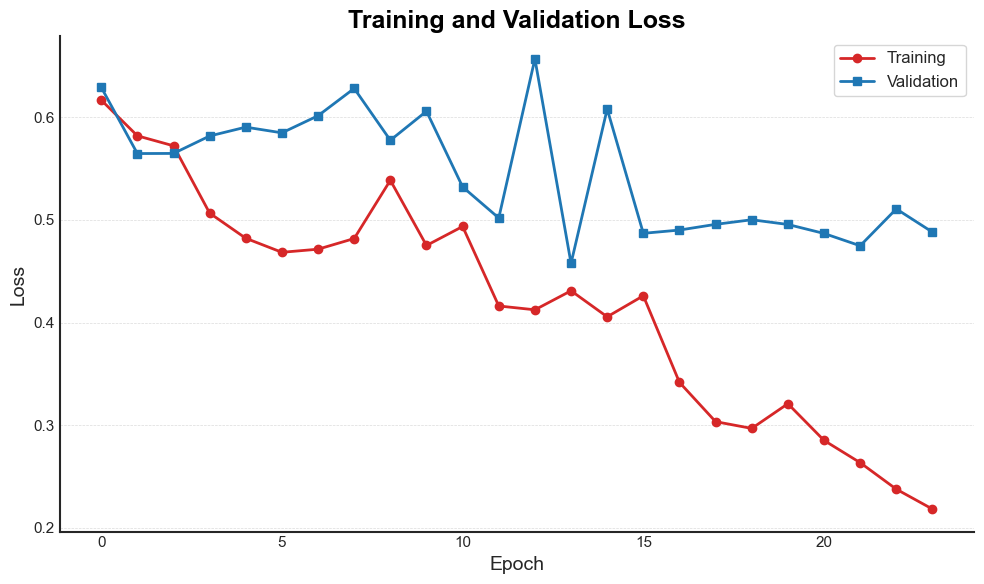

In [9]:
# 构造参数字典
params2 = {
    "train_args": {
        "model_name": LSTM,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.CrossEntropyLoss(),
        "patience": 10,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/LSTM",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'input_dim': 200, # 等同于vector_size
        'hidden_dim': 128,
        'num_classes': 2,
    },
}
model = train(**params2)

### 模型预测

In [10]:
def predict(predict_args, model_args):
    # 参数配置
    texts = predict_args['texts']
    stopwords_path = predict_args['stopwords_path']
    model_name = predict_args['model_name']
    tokenizer = predict_args['tokenizer']
    word_embedding_model = predict_args['word_embedding_model']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    max_length = predict_args['max_length']

    # 检查可用device
    device = torch.device(device)

    # 加载分词器
    sentences = tokenizer(texts, stopwords_path)

    # 加载预训练的词向量模型
    word_embedding_model = word_embedding_model

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 填充到固定长度
    def pad_sequence(sequences, max_length, padding_value=0):
        padded_sequences = [
            torch.cat(
                (seq, torch.full((max_length - seq.size(0), seq.size(1)), padding_value))
            ) if seq.size(0) < max_length else seq[:max_length]
            for seq in sequences
        ]
        return torch.stack(padded_sequences)

    # 将分词结果转换为词向量
    word_vectors = []
    for words in sentences:
        # 将每个句子的词向量转换为张量
        word_vector = [torch.tensor(word_embedding_model.wv[word], dtype=torch.float32)
                       for word in words if word in word_embedding_model.wv]
        if word_vector:  # 确保句子中有词向量
            word_vectors.append(torch.stack(word_vector))

    # 将句子截断到最大长度
    truncated_word_vectors = [vec[:max_length] for vec in word_vectors]

    # 使用 pad_sequence 填充
    padded_word_vectors = pad_sequence(
        truncated_word_vectors, max_length=128, padding_value=0.0)

    # 模型预测
    model.eval()
    with torch.no_grad():
        X_true = padded_word_vectors.to(device)
        outputs = model(X_true)
        _, preds = torch.max(outputs, dim=1)
        labels = preds.cpu().detach().numpy()

    # 将原始数据与预测数据合并输出
    y_pred = pd.DataFrame({'text': texts, 'label': labels})

    return y_pred

In [11]:
# 构造参数字典
params3 = {
    "predict_args": {
        "model_name": LSTM,
        "model_path": "../outputs/best_models/LSTM/checkpoint.pth",
        "texts": [data['review'][4000], data['review'][7000]],
        "stopwords_path": '../data/stop_words.txt',
        "tokenizer": tokenizer,
        "word_embedding_model": fasttext_model,
        "max_length": 128,
        "device": 'cpu'
    },
    "model_args": {
        'input_dim': 200, # 等同于vector_size
        'hidden_dim': 128,
        'num_classes': 2,
    },
}
y_pred = predict(**params3)

In [12]:
y_pred

,text,label
0,这家酒店不错，入住的30楼，可以直接看到玄武湖，风景不错，房里的飘窗做得有特色，喜欢！床也很...,1
1,"房间隔音极差,邻房说话声音清晰可闻,任何杂音清晰入耳,提供的设施品质极差,电熨斗品质不佳还得...",0
